In [ ]:
%load_ext autoreload

In [ ]:
import asyncio
from pathlib import Path
from typing import Annotated, Literal

from dspy import ChainOfThought, InputField, OutputField, Signature
from langchain.tools import tool
from langchain_core.documents import Document
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_tavily import TavilySearch
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from config import config
from data_processing import (
    load_and_process_csv,
    load_documents_from_csv,
    split_documents,
)
from embeddings import initialize_embeddings
from evaluation import (
    RAGEvaluator,
    evaluate_rag_pipeline,
    generate_test_dataset,
)
from formatting import format_messages
from prompts import scratchpad_prompt
from rag_chain import RAGOutput
from retrieval import build_retriever
from retrieval_formatter import RetrieverReportGenerator
from source_formatter import SourceFormatter
from utils import print_separator, setup_environment

In [ ]:
# from pubmed_scraper import PubMedScraper

# scraper = PubMedScraper(email = "olandechris@gmail.com")

# df = scraper.search_with_llm(query = "find me 50 papers about covid 19 from 2019 to 2025 by anthony fauci")

In [ ]:
def prepare_data(input_csv: str, output_csv: str | Path | None = None) -> Path:
    """
    Prepare and process the input data.

    Args:
        input_csv: Path to input CSV file
        output_csv: Path to save processed CSV (optional)

    Returns:
        Path to the processed CSV file
    """
    print_separator("DATA PREPARATION")
    if output_csv is None:
        output_csv = Path(config.paths.data_dir) / "tests.csv"

    # Load and process CSV
    print(f"Loading data from {input_csv}")
    df = load_and_process_csv(input_csv, output_csv)

    return Path(output_csv)

In [ ]:
def build_rag_system(csv_path: str):
    """
    Build the complete RAG system.

    Args:
        csv_path: Path to processed CSV file

    Returns:
        Tuple of (rag_chain, splitted_documents, embeddings)
    """
    print_separator("BUILDING RAG SYSTEM")
    print("Initializing Embeddings ...")

    embeddings = initialize_embeddings(
        model_name=config.model.embedding_model,
        cache_dir=config.model.embedding_cache_dir,
    )

    # Load and split the documents
    print("Loading documents...")
    documents = load_documents_from_csv(csv_path)

    print("Splitting documents...")
    splitted_documents = split_documents(documents, embeddings)
    print(f"Created {len(splitted_documents)} document chunks")

    # Build Retriever
    print("Building retriever")
    retriever = build_retriever(splitted_documents, embeddings, config.retriever)

    # Initialize RAG Chain
    print("Initializing RAG Chain ...")

    # Initialize RAG chain
    print("Initializing RAG chain...")
    rag_chain = RAGOutput(
        prompt_name="rlm/rag-prompt",
        retriever=retriever,
        llm_model=config.model.deepseek_model,
    )
    rag_chain.create_chain()

    print("RAG system built successfully")
    return rag_chain, splitted_documents, embeddings

In [ ]:
def run_evaluation(
    rag_chain: RAGOutput,
    test_dataset_path: str | Path | None = None,
    results_path: str | Path | None = None,
):
    """
    Run evaluation on the RAG system.

    Args:
        rag_chain: Configured RAG chain
        test_dataset_path: Path to test dataset (optional)
        results_path: Path to save results (optional)
    """
    print_separator("EVALUATION")

    if test_dataset_path is None:
        test_dataset_path = config.paths.rag_eval_dir / "generated_testset.csv"

    if results_path is None:
        results_path = config.paths.rag_eval_dir / "results_deepseek_fastembed.csv"

    # Run evaluation
    results = evaluate_rag_pipeline(
        rag_chain=rag_chain,
        input_csv_path=str(test_dataset_path),
        output_csv_path=str(results_path),
        question_column="user_input",
    )

    print(f"Evaluation complete. Results shape: {results.shape}")
    return results

In [ ]:
def generate_synthetic_testset(
    splitted_documents, embeddings, llm, testset_size: int = 10
):
    """
    Generate synthetic test dataset using RAGAS.

    Args:
        splitted_documents: Split documents
        embeddings: Embeddings model
        llm: Language model
        testset_size: Number of test samples

    Returns:
        Generated test dataset as DataFrame
    """
    print_separator("GENERATING TEST DATASET")

    output_path = config.paths.rag_eval_dir / "generated_testset.csv"

    dataset = generate_test_dataset(
        documents=splitted_documents,
        embeddings=embeddings,
        llm=llm,
        testset_size=testset_size,
        output_path=str(output_path),
    )

    print(f"Test dataset generated with {len(dataset)} samples")
    return dataset

In [ ]:
def run_full_evaluation(embeddings):
    """
    Run comprehensive evaluation using RAGEvaluator.

    Args:
        embeddings: Embeddings model to use for evaluation

    Returns:
        Dictionary of evaluation results for all model pairs
    """
    print_separator("COMPREHENSIVE EVALUATION")

    # Initialize evaluator
    evaluator = RAGEvaluator(
        max_workers=1,
        timeout=180,
        generative_models=["deepseek-chat"],
        embedding_models=["fastembed"],
    )

    # Run evaluation for all model pairs
    results = evaluator.evaluate_all_models(
        evaluation_embeddings=embeddings, results_dir=str(config.paths.rag_eval_dir)
    )

    # Print summary
    print_separator("EVALUATION SUMMARY")
    for model_pair, df in results.items():
        print(f"\n{model_pair}:")
        print(f"  Shape: {df.shape}")
        if len(df) > 0:
            metric_cols = [
                col
                for col in df.columns
                if col
                not in ["user_input", "reference", "response", "retrieved_contexts"]
            ]
            if metric_cols:
                print(f"  Metrics: {', '.join(metric_cols)}")
                for col in metric_cols:
                    if df[col].dtype in ["float64", "int64"]:
                        print(f"    {col}: {df[col].mean():.4f} (avg)")

    return results

# Program Entry

In [ ]:
# Setup environment
setup_environment()

# Initialize configuration
print_separator("INITIALIZING")
print(f"Data directory: {config.paths.data_dir}")
print(f"RAG evaluation directory: {config.paths.rag_eval_dir}")

llm = config.initialize_llm()
dspy_lm = config.initialize_dspy()
# Prepare data
csv_path = prepare_data("data/gaza_war_impact_children.csv")

# Build RAG system
rag_chain, splitted_documents, embeddings = build_rag_system(str(csv_path))

# Generate test dataset
# generate_synthetic_testset(splitted_documents, embeddings, llm, testset_size=10)

# Run evaluation
# results = run_evaluation(rag_chain)

# eval_results = run_full_evaluation(embeddings)


================================= INITIALIZING =================================

Data directory: data
RAG evaluation directory: RAGEvaluation

=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv

============================= BUILDING RAG SYSTEM =============================

Initializing Embeddings ...
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index
Initializing RAG Chain ...
Initializing RAG chain...
RAG system built successfully


# Iteration II

In [ ]:
csv_path = prepare_data("data/gaza_war_impact_children.csv")
#  Load and split the documents
print("Loading documents...")
documents = load_documents_from_csv(csv_path)

print("Splitting documents...")
splitted_documents = split_documents(documents, embeddings)
print(f"Created {len(splitted_documents)} document chunks")

# Build Retriever
print("Building retriever")
retriever = build_retriever(splitted_documents, embeddings, config.retriever)


=============================== DATA PREPARATION ===============================

Loading data from data/gaza_war_impact_children.csv
Saved processed data to data/tests.csv
Loading documents...
Splitting documents...
Created 24 document chunks
Building retriever
Loading existing FAISS index from faiss_index


In [ ]:
retriever

ContextualCompressionRetriever(base_compressor=DocumentCompressorPipeline(transformers=[EmbeddingsFilter(embeddings=FastEmbed(fe=<fastembed.text.text_embedding.TextEmbedding object at 0x704a3d8a1400>), similarity_fn=<function cosine_similarity at 0x704a45a53600>, k=20, similarity_threshold=0.6), EmbeddingsRedundantFilter(embeddings=FastEmbed(fe=<fastembed.text.text_embedding.TextEmbedding object at 0x704a3d8a1400>), similarity_fn=<function cosine_similarity at 0x704a45a53600>, similarity_threshold=0.95), FastEmbedRerank(model_name='Xenova/ms-marco-miniLM-L-6-v2', cache_dir='~/.cache/fastembed', top_n=5, encoder=<fastembed.rerank.cross_encoder.text_cross_encoder.TextCrossEncoder object at 0x704a34af4550>)]), base_retriever=EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x704a3d8be710>, k=15), VectorStoreRetriever(tags=['FAISS', 'FastEmbed'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x704a3d8bfb10>, search_kwargs={'k': 15}

In [ ]:
def deduplicate_documents(documents: list[list[Document]]):
    seen = set()
    unique_docs = []

    for doc_list in documents:
        for doc in doc_list:
            if doc.page_content not in seen:
                seen.add(doc.page_content)
                unique_docs.append(doc)

    return unique_docs

In [ ]:
class MultiQueryGenerator(Signature):
    """
    Generate multiple semantically diverse versions of a query to improve retrieval.

    Purpose:
        - Rephrase the input query into several natural language variants
        - Maintain the original meaning while exploring different semantic angles
        - Optimize for both vector-based and keyword-based retrieval systems

    Guidelines:
        - Ensure queries are diverse (avoid redundancy)
        - Keep phrasing natural and conversational
        - Highlight key concepts most relevant to the original question
        - Do not change the query’s core intent

    Example:
        Input: "Impact of Gaza war on children"
        Output:
            - "Effects of Gaza conflict on child health and education"
            - "Psychological trauma among Palestinian youth in Gaza"
            - "Humanitarian impact of war on Gaza’s children"
    """

    question = InputField(
        desc="Original user query to expand into multiple rephrased variants"
    )
    num_queries: int = InputField(
        desc="Number of distinct queries to generate (recommended 3–5)"
    )

    search_queries: list[str] = OutputField(
        desc="List of semantically diverse queries that preserve the original intent"
    )

In [ ]:
query_optimizer = ChainOfThought(MultiQueryGenerator)
response = query_optimizer(
    question="Kurt Cobain is the best grunge artist ever", num_queries=3
)
response.search_queries

['Kurt Cobain influence and legacy in grunge music',
 'Why is Kurt Cobain considered the top grunge artist',
 "Kurt Cobain's impact compared to other grunge musicians"]

In [ ]:
dspy_lm.inspect_history()





[2025-10-10T11:43:02.412707]

System message:

Your input fields are:
1. `question` (str): Original user query to expand into multiple rephrased variants
2. `num_queries` (int): Number of distinct queries to generate (recommended 3–5)
Your output fields are:
1. `reasoning` (str): 
2. `search_queries` (list[str]): List of semantically diverse queries that preserve the original intent
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## question ## ]]
{question}

[[ ## num_queries ## ]]
{num_queries}

[[ ## reasoning ## ]]
{reasoning}

[[ ## search_queries ## ]]
{search_queries}        # note: the value you produce must adhere to the JSON schema: {"type": "array", "items": {"type": "string"}}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Generate multiple semantically diverse versions of a query to improve retrieval.
        
        Purpose:
            - Rephrase the input query into several natu

In [ ]:
@traceable(name="Multiquery Generator")
def generate_queries(question: str, num_queries: int = 2):
    if not question.strip():
        logger.error("Empty query provided")
        return [question]

    try:
        query_optimizer = ChainOfThought(MultiQueryGenerator)
        return query_optimizer(
            question=question, num_queries=num_queries
        ).search_queries
    except Exception as e:
        logger.error(f"An error occurred during query generation: {str(e)}")
        return [question]


generate_queries(question="Impact of the Gaza war on children")

['Humanitarian and health effects of Gaza conflict on children',
 'Psychological trauma and mental health impact on children in Gaza war']

In [ ]:
@tool
async def retriever_tool(search_query: str):
    """
    Retrieves pubmed data using the provided query and generates a report in markdown format.
    """
    report_gen = RetrieverReportGenerator()
    search_queries = generate_queries(question=search_query)

    tasks = [retriever.ainvoke(q) for q in search_queries]
    results = await asyncio.gather(*tasks)

    valid_results = [r for r in results if r]

    if not valid_results:
        return "No relevant documents found for the given query"

    deduplicated_results = deduplicate_documents(valid_results)
    report = report_gen.create_report(deduplicated_results)
    return report["markdown"]

In [ ]:
report = asyncio.run(
    retriever_tool.ainvoke("Impact of the Gaza war on children mental wellbeing")
)

In [ ]:
async def tavily_search_async(
    search_query: str,
    max_results: int = 2,
    num_queries: int = 2,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    if not search_query.strip():
        logger.warning("The search query cannot be an empty string")

    try:
        tavily_search = TavilySearch(
            max_resutls=max_results,
            num_queries=num_queries,
            include_raw_content=include_raw_content,
            topic=topic,
        )
        # Generate multiple queries from the single query
        try:
            search_queries = generate_queries(
                question=search_query, num_queries=num_queries
            )
        except Exception as e:
            logger.warning(
                f"Failed to generate query variations, using original query: {str(e)}"
            )
            search_queries = [search_query]
        # Execute the searches concurrently
        tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
        results = await asyncio.gather(*tasks)
        return results
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []


@tool
async def web_search(
    search_query: str,
    max_results: int = 1,
    include_raw_content: bool = True,
    markdown_output: bool = False,
):
    """
    Search the web for the given search queries.
    """
    try:
        formatter = SourceFormatter(markdown_output=markdown_output)
        search_response = await tavily_search_async(
            search_query,
            max_results=max_results,
            include_raw_content=include_raw_content,
        )
        deduplicated_response = formatter.deduplicate_and_format_sources(
            search_response
        )
        return deduplicated_response
    except Exception as e:
        logger.error(f"An error occurred during web search: {str(e)}")
        return []

In [ ]:
web_response = asyncio.run(
    web_search.ainvoke("Impact of the Gaza war on children's mental wellbeing")
)

2025-10-10 09:44:14 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-10-10 09:44:14 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 9 unique sources


# Offload the context

In [ ]:
class ScratchpadState(BaseModel):
    """State that includes conversation messages and a persistent scratchpad."""

    messages: Annotated[list[AnyMessage], add_messages]
    scratchpad: str = Field(
        default="",
        description="Persistent scratchpad for storing important context and notes",
    )


class WriteToScratchpad(BaseModel):
    """Write or append to the scratchpad for context retention"""

    notes: str = Field(description="The notes to write to the scratchpad")
    mode: Literal["append", "replace"] = Field(
        default="append",
        description="'append' adds to existing notes, 'replace' overwrites the existing notes",
    )


class ReadFromScratchpad(BaseModel):
    """Read context from scratchpad"""

    query: str = Field(
        default="all",
        description="What to look for in the scratchpad. Use 'all' for everything",
    )


class ClearScratchpad(BaseModel):
    """Clear the scratchpad to free up context"""

    confirm: bool = Field(
        description="Must be True to confirm the clearing of the scratchpad"
    )


class SummarizeScratchpad(BaseModel):
    """Compress scratchpad contents to reduce token usage"""

    sections: list[str] | None = Field(
        default=None, description="Sections to summarize. None means all sections"
    )
    target_reduction: float = Field(
        default=0.5,
        ge=0.1,
        le=0.9,
        description="Target token reduction ratio (0.5 = reduce by 50%)",
    )


tools = [
    WriteToScratchpad,
    ReadFromScratchpad,
    ClearScratchpad,
    web_search,
    retriever_tool,
]
llm_with_tools = llm.bind_tools(tools)

# Create tool registry for easier lookup (map name -> tool object)
tool_by_name = {
    (tool.name if hasattr(tool, "name") else tool.__name__): tool for tool in tools
}

In [ ]:
def llm_call(state: ScratchpadState):
    system_message_content = scratchpad_prompt
    if state.scratchpad:
        system_message_content += f"\n\nCURRENT SCRATCHPAD:\n{state.scratchpad}"

    messages = [SystemMessage(system_message_content)] + state.messages
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [ ]:
async def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and update state accordingly."""
    last_message = state.messages[-1]

    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        return {"messages": []}

    result_messages = []
    scratchpad_update = None

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_call_id = tool_call["id"]

        # Handle WriteToScratchpad
        if tool_name == "WriteToScratchpad":
            notes = tool_args.get("notes", "")
            mode = tool_args.get("mode", "append")

            if mode == "replace":
                scratchpad_update = notes
                result_messages.append(
                    ToolMessage(
                        content=f"Wrote to scratchpad: {notes}",
                        tool_call_id=tool_call_id,
                    )
                )
            else:  # append
                separator = "\n\n" if state.scratchpad else ""
                scratchpad_update = f"{state.scratchpad}{separator}{notes}"
                result_messages.append(
                    ToolMessage(
                        content=f"Wrote to scratchpad: {notes}",
                        tool_call_id=tool_call_id,
                    )
                )

        # Handle ReadFromScratchpad
        elif tool_name == "ReadFromScratchpad":
            scratchpad_content = (
                state.scratchpad if state.scratchpad else "Scratchpad is empty."
            )
            query = tool_args.get("query", "all")

            if query != "all":
                content = (
                    f"Scratchpad contents (query: '{query}'):\n\n{scratchpad_content}"
                )
            else:
                content = f"Scratchpad contents:\n\n{scratchpad_content}"

            result_messages.append(
                ToolMessage(content=content, tool_call_id=tool_call_id)
            )

        # Handle ClearScratchpad
        elif tool_name == "ClearScratchpad":
            confirm = tool_args.get("confirm", False)

            if confirm:
                scratchpad_update = ""
                result_messages.append(
                    ToolMessage(
                        content="Scratchpad cleared successfully.",
                        tool_call_id=tool_call_id,
                    )
                )
            else:
                result_messages.append(
                    ToolMessage(
                        content="Scratchpad clear cancelled (confirm=False).",
                        tool_call_id=tool_call_id,
                    )
                )

        # Handle external tools (like Tavily search)
        else:
            tool = tool_by_name[tool_name]
            observation = await tool.ainvoke(tool_args)
            result_messages.append(
                ToolMessage(content=str(observation), tool_call_id=tool_call_id)
            )

    # Build the update dict
    update = {"messages": result_messages}
    if scratchpad_update is not None:
        update["scratchpad"] = scratchpad_update

    return update

In [ ]:
def tools_condition(state: ScratchpadState):
    """Determine whether to call tools or end the agent loop."""
    last_message = state.messages[-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END

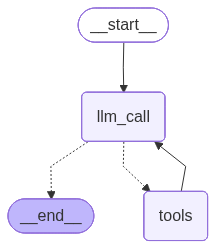

In [ ]:
agent_builder = StateGraph(ScratchpadState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node)
agent_builder.set_entry_point("llm_call")
agent_builder.add_edge("tools", "llm_call")
agent_builder.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", END: END}
)

graph = agent_builder.compile()
graph

In [ ]:
async def run_agent_example():
    # Initial state
    initial_state = ScratchpadState(
        messages=[
            HumanMessage(
                content="What are the impacts of the Israel-Gaza war on children's mental well-being?"
            )
        ],
        scratchpad="",
    )

    # Run the agent
    result = await graph.ainvoke(initial_state)

    format_messages(result["messages"])


asyncio.run(run_agent_example())

2025-10-10 13:04:04 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-10-10 13:04:04 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 10 unique sources


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the impacts of the Israel-Gaza war on children's mental well-being?                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the impacts of the Israel-Gaza war on children's mental well-being. Let me start by      │
│ examining my scratchpad for any previous related research and then conduct a systematic investigation.          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Scratchpad contents:                                                                                            │
│                                                                                                                 │
│ Scratchpad is empty.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll develop a research plan and begin investigating this important topic systematically.                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RESEARCH PLAN: Israel-Gaza War Children's Mental Health Impacts (2023-2024)                │
│ Clinical Context: Ongoing conflict with significant civilian casualties and displacement                        │
│ Research Objectives:                                                                                            │
│ 1. Immediate psychological trauma effects                                                                       │
│ 2. Long-term mental health consequences                                                                         │
│ 3. Specific trauma types (war exposure, displacement, loss)                                                     │
│ 4. Protective factors and interventions                                                                         │
│ 5. Cultural and contextual considerations                                                                       │
│                                                                                                                 │
│ Key Questions:                                                                                                  │
│ - PTSD prevalence and symptom patterns                                                                          │
│ - Anxiety, depression, developmental impacts                                                                    │
│ - Intergenerational trauma transmission                                                                         │
│ - Access to mental health services                                                                              │
│ - Evidence-based interventions                                                                                  │
│                                                                                                                 │
│ Search Strategy: Medical literature database first (trauma, PTSD, child psychology), then current humanitarian  │
│ reports                                                                                                         │
│ Evidence Hierarchy: Peer-reviewed studies > systematic reviews > clinical guidelines > humanitarian             │
│ organization reports                                                                                            │
│ Initial Hypothesis: Severe and widespread mental health impacts requiring urgent intervention                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me start with the medical literature database to understand the evidence base for war-related trauma in     │
│ children.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ # Research Findings Report                                                                                      │
│ *Generated on October 10, 2025 at 01:03 PM*                                                                     │
│                                                                                                                 │
│ **Summary:**                                                                                                    │
│ - Total unique documents: 5                                                                                     │
│ - Total chunks processed: 7                                                                                     │
│                                                                                                                 │
│ ## Report Statistics                                                                                            │
│                                                                                                                 │
│ - **Total Documents:** 5                                                                                        │
│ - **Total Chunks:** 7                                                                                           │
│                                                                                                                 │
│ ### Documents with Multiple Chunks:                                                                             │
│ - https://www.ncbi.nlm.nih.gov/pubmed/30702385: 2 chunks                                                        │
│ - https://www.ncbi.nlm.nih.gov/pubmed/22491534: 2 chunks                                                        │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## 1. Post-traumatic stress in war veterans and secondary traumatic stress among parents of war veterans five   │
│ years after the 2014 Israel-Gaza military conflict.                                                             │
│ **Authors:** Leshem Shahaf, Keha Eldad, Kalanthroff Eyal                                                        │
│ **Publication Date:** 2023                                                                                      │
│ **URL:** https://www.ncbi.nlm.nih.gov/pubmed/37497596                                                           │
│ **References:** American Psychiatric Association . (2013). Diagnostic and statistical manual of mental          │
│ disorders (5th ed.). Washington, DC: American Psychiatric Publishing. | Canfield, J. (2005). Secondary          │
│ traumatization, burnout, and vicarious traumatization: A review of the literature as it relates to therapists   │
│ who treat trauma. Smith College Studies in Social Work, 75(2), 81–101. 10.1300/J497v75n02_06 | Dagan, S. W.,    │
│ Ben-Porat, A., & Itzhaky, H. (2016). Child protection workers dealing with child abuse: The contribution of     │
│ personal, social and organizational resources to secondary traumatization. Child Abuse & Neglect, 51, 203–211.  │
│ 10.1016/j.chiabu.2015.10.008 https://pubmed.ncbi.nlm.nih.gov/26549769 | David, D., Woodward, C., Esquenazi, J., │
│ & Mellman, T. A. (2004). Comparison of comorbid physical illnesses among veterans with PTSD and veterans with   │
│ alcohol dependence. Psychiatric Services, 55(1), 82–85. 10.1176/appi.ps.55.1.82                                 │
│ https://pubmed.ncbi.nlm.nih.gov/14699207 | Dinshtein, Y., Dekel, R., & Polliack, M. (2011). Secondary           │
│ traumatization among adult children of PTSD veterans: T

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me update my scratchpad with these initial findings and conduct additional searches to get more current │
│ and comprehensive information.                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: RETRIEVER ANALYSIS - Initial Medical Literature Findings (5 studies):                      │
│                                                                                                                 │
│ KEY EVIDENCE:                                                                                                   │
│ 1. PTSD Prevalence: 58-80% in Gaza children (Veronese et al., 2018) - Level B evidence                          │
│ 2. Transgenerational Trauma: Family communication patterns affect child mental health (Dalgaard et al., 2019) - │
│ Level B                                                                                                         │
│ 3. Life Satisfaction as Protective Factor: Moderates trauma impact via positive emotions (Veronese study) -     │
│ Level B                                                                                                         │
│ 4. Secondary Traumatic Stress: Parents of war veterans show STS symptoms (Leshem et al., 2023) - Level B        │
│ 5. Health Perception Impact: 100% of parents reported poor child health post-war (Basak, 2012) - Level C        │
│                                                                                                                 │
│ EVIDENCE GAPS:                                                                                                  │
│ - Limited data on current 2023-2024 conflict                                                                    │
│ - Need for updated prevalence studies                                                                           │
│ - Intervention effectiveness data lacking                                                                       │
│ - Cultural-specific protective factors                                                                          │
│                                                                                                                 │
│ SUPPLEMENTARY RESEARCH NEEDED:                                                                                  │
│ - Current humanitarian reports (2023-2024)                                                                      │
│ - UNICEF/WHO mental health assessments                                                                          │
│ - Recent trauma exposure patterns                                                                               │
│ - Access to mental health services data                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me conduct web searches to get current information about the 2023-2024 conflict impacts.                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Sources:                                                                                                        │
│                                                                                                                 │
│ Source 1: Full article: Gaza's hidden crisis: adults, children, and generations of ...                          │
│                                                                                                                 │
│ URL: https://www.tandfonline.com/doi/full/10.1080/20008066.2024.2416824                                         │
│                                                                                                                 │
│ Most relevant content: Children in Gaza are at significant risk of long-term mental and physical health issues, │
│ including PTSD, anxiety, depression, and chronic                                                                │
│                                                                                                                 │
│ Note: No raw content available for this source                                                                  │
│ ==================================================                                                              │
│                                                                                                                 │
│ Source 2: The Psychological Toll of War and Forced Displacement in Gaza                                         │
│                                                                                                                 │
│ URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC12033650/                                                         │
│                                                                                                                 │
│ Most relevant content: Moderate or higher levels of anxiety and depression were reported by 79.3% and 84.5%,    │
│ respectively. The rate of symptomatic PTSD was 67.8% when                                                       │
│                                                                                                                 │
│ Full source content (limited to ~1250 tokens):                                                                  │
│                                                                                                                 │
│ The Psychological Toll of War and Forced Displacement in Gaza: A Study on Anxiety, PTSD, and Depression - PMC   │
│                                                                                                                 │
│ ===============                                                                                                 │
│ [Skip to main content](https://pmc.ncbi.nlm.nih.gov/articles/PMC12033650/#main-content)                         │
│                                                                                                                 │
│ ![Image 1](https://pmc.ncbi.nlm.nih.gov/static/img/us_flag.svg)                                                 │
│                                                                                                                 │
│ An official website of the United States government                                                             │
│                                                                                                                 │
│ Here's how you know                                                                                             │
│                                                                                                                 │
│ Here's how you know                                                                                             │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me update my scratchpad with the current findings and synthesize the evidence.                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Wrote to scratchpad: CURRENT RESEARCH FINDINGS - 2023-2024 Conflict:                                            │
│                                                                                                                 │
│ STATISTICAL OVERVIEW (UNICEF/WHO Data):                                                                         │
│ - Over 14,000 children killed since October 2023 (UNICEF, 2025)                                                 │
│ - Over 34,000 children wounded                                                                                  │
│ - Nearly 1 million children repeatedly displaced                                                                │
│ - 100% of Gaza's 1.2 million children need mental health support (UNICEF, 2024) - unprecedented statement       │
│                                                                                                                 │
│ MENTAL HEALTH PREVALENCE (2024 Studies):                                                                        │
│ - PTSD: 67.8% symptomatic (Aldabbour et al., 2025) - Level B evidence                                           │
│ - Anxiety: 79.3% moderate or higher levels                                                                      │
│ - Depression: 84.5% moderate or higher levels                                                                   │
│ - Pre-existing baseline (2020): 53.5% of Gazan children had PTSD before current conflict                        │
│                                                                                                                 │
│ COMPLEX CONTINUOUS TRAUMA (CCT) PATTERNS:                                                                       │
│ - Ongoing exposure to multiple traumatic events since early childhood                                           │
│ - Complex PTSD symptoms (emotional dysregulation, identity disturbance, relationship difficulties)              │
│ - Sleep disturbances: 68% of children, primarily fear of warplanes (78%)                                        │
│ - 95% of children exhibit mental health challenges (Save the Children, 2018)                                    │
│                                                                                                                 │
│ RISK FACTORS IDENTIFIED:                                                                                        │
│ - Mass displacement (average 6-7 times per child)                                                               │
│ - Loss of family members (many witnessed deaths)                                                                │
│ - Destruction of homes and communities                                                                          │
│ - Constant bombardment and insecurity                                                                           │
│ - Severe food shortages and malnutrition                                                                        │
│ - Collapse of health and education systems                                                                      │
│                                                                                                                 │
│ PROTECTIVE FACTORS FROM PREVIOUS RESEARCH:                                                                      │
│ - Life satisfaction moderates trauma impact via positive emotions (Veronese, 2018)                              │
│ - Family communication about trauma facts/reasons/meanings protects against PTSD (Dalgaard, 2019)               │
│ - Positive affect regulation strategies ("TV method" visualization techniques)                                  │
│                                                                                                                 │
│ CLINICAL IMPLICATIONS:                                 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my comprehensive research, I can now provide you with a detailed analysis of the impacts of the        │
│ Israel-Gaza war on children's mental well-being.                                                                │
│                                                                                                                 │
│ ## The Devastating Impacts of the Israel-Gaza War on Children's Mental Well-Being                               │
│                                                                                                                 │
│ The Israel-Gaza conflict since October 2023 has created an unprecedented mental health crisis for children,     │
│ with consequences that will likely affect generations. Here are the key findings from current evidence:         │
│                                                                                                                 │
│ ### **Scale and Severity of the Crisis**                                                                        │
│                                                                                                                 │
│ **Unprecedented Population-Level Impact:**                                                                      │
│ - **100% of Gaza's 1.2 million children need mental health support** (UNICEF, 2024) - the first time in history │
│ UNICEF has declared every child in a population needs psychological intervention                                │
│ - Over 14,000 children killed and 34,000 wounded since October 2023 (UNICEF, 2025)                              │
│ - Nearly 1 million children have been repeatedly displaced, many 6-7 times                                      │
│                                                                                                                 │
│ ### **Mental Health Prevalence Rates (2024-2025 Data)**                                                         │
│                                                                                                                 │
│ **Current Conflict Period:**                                                                                    │
│ - **PTSD**: 67.8% symptomatic (Aldabbour et al., 2025)                                                          │
│ - **Anxiety**: 79.3% moderate or higher levels                                                                  │
│ - **Depression**: 84.5% moderate or higher levels                                                               │
│                                                                                                                 │
│ **Pre-Conflict Baseline (2020):**                                                                               │
│ - 53.5% of Gazan children already had PTSD before the current conflict, indicating cumulative trauma            │
│ - 95% exhibited mental health challenges (Save the Children, 2018)                                              │
│                                                                                                                 │
│ ### **Complex Continuous Trauma (CCT) Patterns**                                                                │
│                                                                                                                 │
│ Children in Gaza experience **complex continuous trauma** - prolonged, repeated exposure to multiple traumatic  │
│ events since early childhood, resulting in:                                                                     │
│                                                                                                                 │
│ - **Complex PTSD symptoms**: Emotional dysregulation, identity disturbance, relationship difficulties           │
│ - **Sleep disturbances**: 68% of children struggle with

# Report Generation

In [ ]:
class Section(BaseModel):
    name: str = Field(
        description="Medical research section title reflecting PubMed study focus (e.g., 'Pediatric Mental Health Outcomes', 'Conflict-Related Injuries', 'Public Health Impact')"
    )
    description: str = Field(
        description="Medical research context explaining what peer-reviewed evidence this section will analyze"
    )
    research: bool = Field(
        description="True if requires current PubMed literature search, systematic reviews, or specific clinical studies. False only for background/methodology sections"
    )
    content: str = Field(
        description="Specific medical evidence requirements: study types needed (RCTs, cohort studies, case reports), population focus, clinical outcomes, or epidemiological data"
    )

    audience_complexity: str = Field(
        description="Medical evidence level: 'clinical_practitioners', 'public_health_officials', 'medical_researchers', or 'policy_makers'",
        default="clinical_practitioners",
    )

    estimated_length: str = Field(
        description="Evidence depth: 'brief', 'standard', or 'comprehensive'",
        default="standard",
    )

    dependencies: list[str] = Field(
        description="Sections that must precede this one for proper medical context",
        default_factory=list,
    )

    success_criteria: str = Field(
        description="Specific medical research outcome or evidence synthesis goal",
        default="",
    )


class Sections(BaseModel):
    sections: list[Section] = Field(
        description="Medical literature review sections following systematic review or evidence synthesis structure"
    )

    total_estimated_length: str = Field(
        description="Medical review scope: 'rapid_review', 'systematic_review', or 'comprehensive_meta_analysis'",
        default="systematic_review",
    )

    primary_audience: str = Field(
        description="Target medical audience: 'clinicians', 'public_health_officials', 'researchers', 'humanitarian_workers', or 'policy_makers'",
        default="clinicians",
    )

    narrative_strategy: str = Field(
        description="Medical research approach: 'systematic_review', 'scoping_review', 'epidemiological_analysis', or 'clinical_evidence_synthesis'",
        default="systematic_review",
    )

In [ ]:
structured_llm = llm.with_structured_output(Sections)
result = structured_llm.invoke("Impact of the Gaza war on children")
result

Sections(sections=[Section(name='Pediatric Mortality and Morbidity', description='Analysis of direct conflict-related child deaths, injuries, and trauma in Gaza', research=True, content='Requires epidemiological data on child mortality rates, injury patterns (blast injuries, shrapnel wounds, burns), and trauma statistics from recent conflict periods. Need peer-reviewed studies, hospital records, and humanitarian organization reports.', audience_complexity='medical_researchers', estimated_length='comprehensive', dependencies=[], success_criteria='Quantitative assessment of direct conflict impact on child survival'), Section(name='Mental Health and Psychosocial Impact', description="Evidence on PTSD, anxiety, depression, and developmental trauma in Gaza's pediatric population", research=True, content='Systematic review of mental health studies, PTSD prevalence, trauma-related disorders, and psychosocial interventions. Need longitudinal studies, clinical assessments, and validated screeni